# Hyperparameters optimisation
## TD 5

This is the version of the TD where I use more images (https://drive.google.com/drive/u/1/folders/1kMhMH5pi_jJNgwNPpy1epXsWCI4Hqsve).

We are essentially going to use the same `Food101` ([credit where it's due](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)) data, the same object `ImageDataset`, the same `DataLoader`.

The code below is mainly a copy of the code from the previous TD, except that global variables are now defined separately and everything is wrapped in different functions. This is to make it easier to train the same model with different hyperparameters and architectures, etc ...

For those that can use their GPUs or are on the DCE, all the necessary `.to(device)` are already in the code.

If, for some reason, you encounter this error: `OutOfMemoryError: CUDA out of memory.`, it means that your GPU does not have enough memory to run the model. You can try to reduce the batch size, or the number of neurons in the network, or the number of layers in the network, or the number of filters in the convolutional layers, etc ...

In [41]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pathlib
import time
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set the random seed for reproducibility
_ = torch.manual_seed(25)

In [42]:
from functools import partial
print = partial(print, flush=True)

In [43]:
# Global variables

# Setup device-agnostic code
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE} device")

# Batch size
BATCH_SIZE = 512

# Learning rate
LEARNING_RATE = 2e-2

# Number of epochs
NUM_EPOCHS = 20

# Number of classes
NUM_CLASSES = 3

# Image size
IMAGE_SIZE = 128

Using cuda device


In [ ]:
class CachedImageFolder(datasets.ImageFolder):
    # We're losing something by doing that, what is it? (A: The datatransforms) How could we fix it? (A: Write your own Dataset)
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cache = {}

    def __getitem__(self, index):
        if index not in self.cache:
            self.cache[index] = super().__getitem__(index)
        return self.cache[index]

In [45]:
def get_datasets_and_dataloaders(
    batch_size: int = 4
) -> tuple[
    DataLoader, 
    DataLoader
]:
    """
    Load the training and test datasets into data loaders.
    """
    data_dir = pathlib.Path(".")
    train_dir = data_dir / "Food-3-big" / "train"
    test_dir = data_dir / "Food-3-big" / "test"

    data_transform_train = transforms.Compose(
        [
            transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),  # Resize the images to 128x128
            transforms.Lambda(lambda img: img.convert("RGB")),
            transforms.ToTensor(),  # Convert the images to tensors
            transforms.RandomHorizontalFlip(p=0.5),  # Flip the images horizontally with probability 0.5
        ]
    )
    data_transform_test = transforms.Compose(
        [
            transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),  # Resize the images to 128x128
            transforms.Lambda(lambda img: img.convert("RGB")),
            transforms.ToTensor(),  # Convert the images to tensors
        ]
    )

    train_data = CachedImageFolder(
        root=str(train_dir),  # target folder of images
        transform=data_transform_train,  # transforms to perform on data (images)
        target_transform=None  # transforms to perform on labels (if necessary)
    ) 

    test_data = CachedImageFolder(
        root=str(test_dir),
        transform=data_transform_test
    )

    train_dataloader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,  # how many samples per batch?
        shuffle=True  # shuffle the data?
    )

    test_dataloader = DataLoader(
        dataset=test_data,
        batch_size=batch_size,
        shuffle=False
    ) # don't usually need to shuffle testing data


    return train_dataloader, test_dataloader

In [46]:
# Load dataloaders in global variables
TRAIN_DATALOADER, TEST_DATALOADER = get_datasets_and_dataloaders(BATCH_SIZE)

In [47]:
# How can we get the datasets? Did we lose them? No
print(TRAIN_DATALOADER.dataset)
print("---")
print(TEST_DATALOADER.dataset)

Dataset CachedImageFolder
    Number of datapoints: 3212
    Root location: Food-3-big\train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               Lambda()
               ToTensor()
               RandomHorizontalFlip(p=0.5)
           )
---
Dataset CachedImageFolder
    Number of datapoints: 447
    Root location: Food-3-big\test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               Lambda()
               ToTensor()
           )


In [48]:
example_tensor = torch.tensor(
    [
        [1, 2, 3, 4],
        [5, 6, 7, 8],
        [9, 10, 11, 12],
        [13, 14, 15, 16]
    ], 
    dtype=torch.float32
)

# First let's go to our configuration: tensor of shape (batch_size, channels, height, width)
print(example_tensor.shape)
example_tensor = example_tensor.unsqueeze(0).unsqueeze(0)  # (N, C, H, W)
print(example_tensor.shape)

# Conv2d with a 2x2 kernel
conv = nn.Conv2d(
    in_channels=1,
    out_channels=1,
    kernel_size=2
)

output = conv(example_tensor)
print(output.shape)
output = output.squeeze()
print(output.shape)

print(output)

torch.Size([4, 4])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 3, 3])
torch.Size([3, 3])
tensor([[-0.1947, -0.2754, -0.3561],
        [-0.5174, -0.5981, -0.6788],
        [-0.8402, -0.9209, -1.0015]], grad_fn=<SqueezeBackward0>)


In [49]:
example_tensor = torch.tensor(
    [
        [1, 2, 3, 4],
        [5, 6, 7, 8],
        [9, 10, 11, 12],
        [13, 14, 15, 16]
    ], 
    dtype=torch.float32
)

# First let's go to our configuration: tensor of shape (batch_size, channels, height, width)
print(example_tensor.shape)
example_tensor = example_tensor.unsqueeze(0).unsqueeze(0)
print(example_tensor.shape)

# max_pool2d with a 2x2 kernel
pool = nn.MaxPool2d(kernel_size=2)
pooled_tensor = pool(example_tensor)
print(pooled_tensor.shape)

pooled_tensor = pooled_tensor.squeeze()
pooled_tensor, pooled_tensor.shape

torch.Size([4, 4])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 2, 2])


(tensor([[ 6.,  8.],
         [14., 16.]]),
 torch.Size([2, 2]))

In [ ]:
class Net(nn.Module):
    def __init__(
        self,
        hidden_units: int = 200,
        batch_norm: bool = False,
        use_conv: bool = False
    ):
        super().__init__()

        self.use_conv: bool = use_conv
        self.batch_norm: bool = batch_norm

        if use_conv:
            self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=not batch_norm)
            self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=not batch_norm)

            if batch_norm:
                self.bn1 = nn.BatchNorm2d(16)
                self.bn2 = nn.BatchNorm2d(32)

            self.pool = nn.MaxPool2d(kernel_size=2)
            conv_output_size = IMAGE_SIZE // 4  # (we will add two poolings of size (2, 2))

            self.fc1 = nn.Linear(32 * conv_output_size * conv_output_size, hidden_units)
        else:
            self.fc1 = nn.Linear(IMAGE_SIZE * IMAGE_SIZE * 3, hidden_units, bias=not batch_norm)
            
            if batch_norm:
                self.bn1 = nn.BatchNorm1d(hidden_units)

        # Shared layers
        self.fc2 = nn.Linear(hidden_units, NUM_CLASSES)

    def forward(self, x):
        if self.use_conv:
            x = self.conv1(x)
            if self.batch_norm:
                x = self.bn1(x)
            x = nn.ReLU()(x)
            x = self.pool(x)

            x = self.conv2(x)
            if self.batch_norm:
                x = self.bn2(x)
            x = nn.ReLU()(x)
            x = self.pool(x)

            # Flatten the features for the fully connected layer
            x = x.view(x.size(0), -1)

            x = self.fc1(x)
            x = nn.ReLU()(x)

        else:
            # Flatten in the beginning for the fully connected layer
            x = x.view(x.size(0), -1)
            x = self.fc1(x)
            if self.batch_norm:
                x = self.bn1(x)
            x = nn.ReLU()(x)

        x = self.fc2(x)
        return x

---

Why does it not work with `x = x.view(BATCH_SIZE, -1)`?

---

In [51]:
# Create model
MODEL: Net = Net(hidden_units=200, batch_norm=False, use_conv=False).to(DEVICE)

In [52]:
def test_our_model() -> float:
    # 0. Put model in eval mode
    MODEL.eval()  # to remove stuff like dropout that's only going to be in the training part

    # 1. Setup test accuracy value
    test_acc: float = 0

    # 2. Turn on inference context manager
    with torch.no_grad():
        # Loop through DataLoader batches
        for X_test, y_test in TEST_DATALOADER:  # majuscule à X car c'est une "matrice", et y un entier
            # a. Move data to device and no need to reshape since it's done in MODEL definition
            X_test_flattened = X_test.to(DEVICE) 
            y_test = y_test.to(DEVICE)

            # b. Forward pass
            model_output = MODEL(X_test_flattened)

            # c. Calculate and accumulate accuracy
            test_pred_label = model_output.argmax(dim=1)
            test_acc += (test_pred_label == y_test).sum()

    # Adjust metrics to get average loss and accuracy per batch
    test_acc = (test_acc.cpu() / (len(TEST_DATALOADER.dataset))).item()
    return test_acc

In [53]:
# Test our untrained model
print((f"{100*test_our_model():.2f}%"))

31.32%


You should get 34.31% accuracy on the testing set without training and with the default hyperparameters if you used the same seed. Close enough to 33% which is the expected accuracy for a random classifier.

We can plot some images like last time

torch.Size([3, 128, 128])
torch.Size([128, 128, 3])


Text(0.5, 1.0, 'pizza')

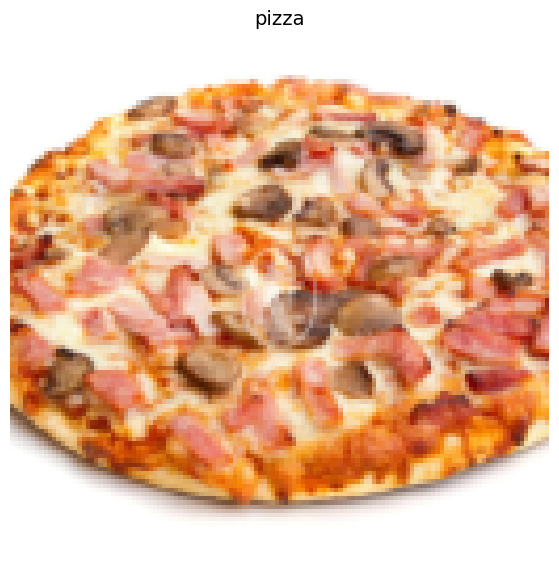

In [54]:
# Get the tensors and put them in the right dimensions for matplotlib
my_pizza = TRAIN_DATALOADER.dataset[0][0]
my_label = TRAIN_DATALOADER.dataset[0][1]
print(my_pizza.shape)
my_pizza_reshaped = my_pizza.permute(1, 2, 0)
print(my_pizza_reshaped.shape)

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(my_pizza_reshaped)
plt.axis("off")
plt.title(TRAIN_DATALOADER.dataset.classes[my_label], fontsize=14)

Let's do the training loop now

In [55]:
def main_train(loss_fn, optimizer) -> None:
    """
    Train the model and modifies the trained model inplace.
    """
    start_time_global = time.time()

    # Put model in train mode
    MODEL.train()

    # Loop through data loader data batches
    for epoch in range(NUM_EPOCHS):
        start_time_epoch = time.time()

        # Setup train loss and train accuracy values
        train_loss, train_acc = 0, 0

        for X, y in TRAIN_DATALOADER:
            # 0. Move data to device
            X = X.to(DEVICE)
            y = y.to(DEVICE)

            # 1. Forward pass
            y_pred = MODEL(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = y_pred.argmax(dim=1)
            train_acc += (y_pred_class == y).sum()

        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / (len(TRAIN_DATALOADER.dataset))
        train_acc = train_acc / (len(TRAIN_DATALOADER.dataset))
        print(
            f"epoch {epoch+1}/{NUM_EPOCHS},"
            f" train_loss = {train_loss:.2e},"
            f" train_acc = {100*train_acc.item():.2f}%,"
            f" time spent during this epoch = {time.time() - start_time_epoch:.2f}s,"
            f" total time spent = {time.time() - start_time_global:.2f}s"
        )

In [56]:
main_train(nn.CrossEntropyLoss(), torch.optim.SGD(MODEL.parameters(), lr=LEARNING_RATE))

epoch 1/20, train_loss = 2.72e-03, train_acc = 36.89%, time spent during this epoch = 13.91s, total time spent = 13.91s
epoch 2/20, train_loss = 2.36e-03, train_acc = 40.75%, time spent during this epoch = 0.21s, total time spent = 14.12s
epoch 3/20, train_loss = 2.35e-03, train_acc = 47.57%, time spent during this epoch = 0.09s, total time spent = 14.21s
epoch 4/20, train_loss = 2.21e-03, train_acc = 53.77%, time spent during this epoch = 0.08s, total time spent = 14.29s
epoch 5/20, train_loss = 2.26e-03, train_acc = 46.36%, time spent during this epoch = 0.08s, total time spent = 14.38s
epoch 6/20, train_loss = 2.18e-03, train_acc = 53.67%, time spent during this epoch = 0.09s, total time spent = 14.46s
epoch 7/20, train_loss = 2.15e-03, train_acc = 50.59%, time spent during this epoch = 0.09s, total time spent = 14.55s
epoch 8/20, train_loss = 2.08e-03, train_acc = 53.08%, time spent during this epoch = 0.11s, total time spent = 14.66s
epoch 9/20, train_loss = 2.01e-03, train_acc = 

In [57]:
print((f"{100*test_our_model():.2f}%"))

54.81%


You should get 58.17% accuracy on the testing set without training and with the default hyperparameters if you used the same seed. And we definitely reached convergence (the loss is not decreasing that much anymore, and if you try to train for more epochs, you will see that the testing set accuracy will decrease). Note that by saying "if you try to train for more epochs, you will see that the testing set accuracy will decrease", we kind of cheated by using the testing set to infer an information about the number of epochs, we should instead use validation sets and cross validation techniques ... and we will (today)! No worries.

-----

Is it possible for `train_loss` to decrease whilst `train_acc` decreases at the same time? Look at what happens between epochs 14 and 15 in this example (it's a real run, different seed though):
```py
epoch 14/15, train_loss = 1.01e-01, train_acc = 63.61%, time spent ...
epoch 15/15, train_loss = 9.91e-02, train_acc = 63.50%, time spent ...
```

Why is that?

-----

## Let's try to improve this accuracy!

You will need to install the Optuna package (`pip install optuna`) and import it at the beginning of your script (no need if you're using the shared environment of the DCE, we installed it for you already). We should also import `KFold` from `sklearn.model_selection`. This is because we will use cross-validation to find the best hyperparameters.

In [58]:
import optuna
from sklearn.model_selection import KFold

First easy task is to decide how many neurons there should be in the hidden layer.
 
We will do this together (optimising the number of hidden nuerons), and then you'll have to implement optimization of the learning rate*, the optimizer's choice on your own. We will also show you how to choose between a convolutional and dense network.

\**Careful! Small learning rates are not always better, especially if you do not change the number of epochs. You should try to find the best learning rate for the number of epochs you chose, one that is not too big for your computer to handle.*

We will need to define a new function that will be used as the objective function for Optuna's optimization. This function should take in the `trial` object from Optuna as an argument and use the `trial` object to define and sample the hyperparameters that you want to optimize. For example, you can use the `trial` object to sample a choice between a convolutional and dense network, and to sample the number of neurons for the chosen network. After training the model, we will need to return the final validation accuracy calculated with cross-validation* as the objective function value for Optuna to maximise.

\*We use cross-validation here (5-fold) because we want to use the testing set as little as possible. We will use the testing set only once, at the end, to get the final accuracy of the best model. But, cross-validation greatly increases the time required to run the algorithms, so we won't always use cross-validation to optimize hyperparameters.

In [59]:
def objective(trial: optuna.trial.Trial) -> float:
    print("New trial")

    # Set up cross validation
    n_splits: int = 5
    fold = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    scores = [0]*n_splits

    hidden_units: int = trial.suggest_int('hidden_units', 2, 50)

    # Loop through data loader data batches
    for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(range(len(TRAIN_DATALOADER.dataset)))):
        # train_idx and valid_idx are numpy arrays of indices of the training and validation sets for this 
        # fold respectively.
        # They do not contain the actual data, but the indices of the data in the dataset.
        # We can use these indices to create a subset of the dataset for this fold with torch.utils.data.Subset.
        # Obviously, if an index is in the validation set, it will not be in the training set. You could
        # check this by printing train_idx and valid_idx and check by yourself.
        
        print(f"Fold {fold_idx+1}/{n_splits}")

        # Create subsets of the dataset for this fold
        sub_train_data = torch.utils.data.Subset(TRAIN_DATALOADER.dataset, train_idx)
        sub_valid_data = torch.utils.data.Subset(TRAIN_DATALOADER.dataset, valid_idx)

        # Create data loaders for this fold
        sub_train_loader = torch.utils.data.DataLoader(sub_train_data, batch_size=BATCH_SIZE, shuffle=True)
        sub_valid_loader = torch.utils.data.DataLoader(sub_valid_data, batch_size=BATCH_SIZE, shuffle=False)
        
        # Generate the model.
        my_model: Net = Net(hidden_units=hidden_units).to(DEVICE)
        
        for epoch in range(NUM_EPOCHS):
            # Training of the model.
            # Put model in train mode
            my_model.train()

            # Set up optimizer
            optimizer = torch.optim.SGD(my_model.parameters(), lr=LEARNING_RATE)

            # Set up loss function
            loss_fn = nn.CrossEntropyLoss()
            for X, y in sub_train_loader:
                # 1. Move data to device
                X = X.to(DEVICE)
                y = y.to(DEVICE)

                # 2. Forward pass
                y_pred = my_model(X)

                # 3. Calculate and accumulate loss
                loss = loss_fn(y_pred, y)

                # 4. Optimizer zero grad
                optimizer.zero_grad()

                # 5. Loss backward
                loss.backward()

                # 6. Optimizer step
                optimizer.step()

        # Validation of the model.
        # Put model in eval mode
        my_model.eval()
        
        val_acc = 0
        with torch.no_grad():
            for X, y in sub_valid_loader:
                # 1. Move data to device
                X = X.to(DEVICE)
                y = y.to(DEVICE)

                # 2. Forward pass
                y_pred = my_model(X)
                
                # 3. Compute accuracy
                y_pred_class = y_pred.argmax(dim=1)

                val_acc += (y_pred_class == y).sum()

        scores[fold_idx] = (val_acc.cpu() / len(sub_valid_data))
        # bring it back otherwise, np.mean will not work
        print(f"Fold {fold_idx+1}/{n_splits} accuracy: {scores[fold_idx]}")
    
    return np.mean(scores)

Finally, we will need to call the `optuna.create_study()` function to create a new study, and use the `study.optimize()` function to run the optimization, passing the objective function that we defined earlier.

You can find more information about how to use Optuna in the [Optuna documentation](https://optuna.readthedocs.io/en/stable/index.html).

In [60]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=1200, n_trials=15) 
# - timeout = 1200 -> stops after 20 minutes;
# - n_trials = 5 -> tries 5 different values for the hyperparameter.

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n")
print("--------------------")
print("--------------------")
print("--------------------")
print("\n")
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print(f"\t{key}: {value}")

[I 2026-01-18 13:57:27,884] A new study created in memory with name: no-name-d8ad5796-742c-4a0d-9386-a960b1cb3bbd


New trial
Fold 1/5
Fold 1/5 accuracy: 0.32814928889274597
Fold 2/5
Fold 2/5 accuracy: 0.3576982915401459
Fold 3/5
Fold 3/5 accuracy: 0.32398754358291626
Fold 4/5
Fold 4/5 accuracy: 0.3208722770214081
Fold 5/5
Fold 5/5 accuracy: 0.32398754358291626


[I 2026-01-18 13:57:34,883] Trial 0 finished with value: 0.33093899488449097 and parameters: {'hidden_units': 2}. Best is trial 0 with value: 0.33093899488449097.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.4634525775909424
Fold 2/5
Fold 2/5 accuracy: 0.35925349593162537
Fold 3/5
Fold 3/5 accuracy: 0.4735202491283417
Fold 4/5
Fold 4/5 accuracy: 0.44859811663627625
Fold 5/5
Fold 5/5 accuracy: 0.32398754358291626


[I 2026-01-18 13:57:41,768] Trial 1 finished with value: 0.4137624204158783 and parameters: {'hidden_units': 50}. Best is trial 1 with value: 0.4137624204158783.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.3405909836292267
Fold 2/5
Fold 2/5 accuracy: 0.33437013626098633
Fold 3/5
Fold 3/5 accuracy: 0.32398754358291626
Fold 4/5
Fold 4/5 accuracy: 0.3208722770214081
Fold 5/5
Fold 5/5 accuracy: 0.3504672944545746


[I 2026-01-18 13:57:48,830] Trial 2 finished with value: 0.33405762910842896 and parameters: {'hidden_units': 3}. Best is trial 1 with value: 0.4137624204158783.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.4167962670326233
Fold 2/5
Fold 2/5 accuracy: 0.4121306240558624
Fold 3/5
Fold 3/5 accuracy: 0.3520249128341675
Fold 4/5
Fold 4/5 accuracy: 0.3208722770214081
Fold 5/5
Fold 5/5 accuracy: 0.37227413058280945


[I 2026-01-18 13:57:56,123] Trial 3 finished with value: 0.37481966614723206 and parameters: {'hidden_units': 34}. Best is trial 1 with value: 0.4137624204158783.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.4121306240558624
Fold 2/5
Fold 2/5 accuracy: 0.3110419809818268
Fold 3/5
Fold 3/5 accuracy: 0.3177570104598999
Fold 4/5
Fold 4/5 accuracy: 0.37227413058280945
Fold 5/5
Fold 5/5 accuracy: 0.3629283607006073


[I 2026-01-18 13:58:03,309] Trial 4 finished with value: 0.35522642731666565 and parameters: {'hidden_units': 13}. Best is trial 1 with value: 0.4137624204158783.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.37636080384254456
Fold 2/5
Fold 2/5 accuracy: 0.40902021527290344
Fold 3/5
Fold 3/5 accuracy: 0.36915886402130127
Fold 4/5
Fold 4/5 accuracy: 0.3598130941390991
Fold 5/5
Fold 5/5 accuracy: 0.49065420031547546


[I 2026-01-18 13:58:10,108] Trial 5 finished with value: 0.4010013937950134 and parameters: {'hidden_units': 27}. Best is trial 1 with value: 0.4137624204158783.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.4152410626411438
Fold 2/5
Fold 2/5 accuracy: 0.5178849101066589
Fold 3/5
Fold 3/5 accuracy: 0.38785046339035034
Fold 4/5
Fold 4/5 accuracy: 0.4517133831977844
Fold 5/5
Fold 5/5 accuracy: 0.3504672944545746


[I 2026-01-18 13:58:16,825] Trial 6 finished with value: 0.42463141679763794 and parameters: {'hidden_units': 15}. Best is trial 6 with value: 0.42463141679763794.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.42457231879234314
Fold 2/5
Fold 2/5 accuracy: 0.3359253406524658
Fold 3/5
Fold 3/5 accuracy: 0.381619930267334
Fold 4/5
Fold 4/5 accuracy: 0.3193146288394928
Fold 5/5
Fold 5/5 accuracy: 0.37227413058280945


[I 2026-01-18 13:58:23,584] Trial 7 finished with value: 0.36674126982688904 and parameters: {'hidden_units': 12}. Best is trial 6 with value: 0.42463141679763794.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.4618973433971405
Fold 2/5
Fold 2/5 accuracy: 0.42146191000938416
Fold 3/5
Fold 3/5 accuracy: 0.3177570104598999
Fold 4/5
Fold 4/5 accuracy: 0.46105918288230896
Fold 5/5
Fold 5/5 accuracy: 0.4719626307487488


[I 2026-01-18 13:58:30,510] Trial 8 finished with value: 0.426827609539032 and parameters: {'hidden_units': 25}. Best is trial 8 with value: 0.426827609539032.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.435458779335022
Fold 2/5
Fold 2/5 accuracy: 0.349922239780426
Fold 3/5
Fold 3/5 accuracy: 0.44859811663627625
Fold 4/5
Fold 4/5 accuracy: 0.3193146288394928
Fold 5/5
Fold 5/5 accuracy: 0.45950156450271606


[I 2026-01-18 13:58:37,382] Trial 9 finished with value: 0.4025590419769287 and parameters: {'hidden_units': 26}. Best is trial 8 with value: 0.426827609539032.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.4587869346141815
Fold 2/5
Fold 2/5 accuracy: 0.43856921792030334
Fold 3/5
Fold 3/5 accuracy: 0.33800622820854187
Fold 4/5
Fold 4/5 accuracy: 0.41277259588241577
Fold 5/5
Fold 5/5 accuracy: 0.4844236671924591


[I 2026-01-18 13:58:45,102] Trial 10 finished with value: 0.4265117049217224 and parameters: {'hidden_units': 41}. Best is trial 8 with value: 0.426827609539032.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.4790046513080597
Fold 2/5
Fold 2/5 accuracy: 0.37791600823402405
Fold 3/5
Fold 3/5 accuracy: 0.46105918288230896
Fold 4/5
Fold 4/5 accuracy: 0.3193146288394928
Fold 5/5
Fold 5/5 accuracy: 0.32554516196250916


[I 2026-01-18 13:58:52,088] Trial 11 finished with value: 0.3925679326057434 and parameters: {'hidden_units': 45}. Best is trial 8 with value: 0.426827609539032.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.49611198902130127
Fold 2/5
Fold 2/5 accuracy: 0.564541220664978
Fold 3/5
Fold 3/5 accuracy: 0.420560747385025
Fold 4/5
Fold 4/5 accuracy: 0.37227413058280945
Fold 5/5
Fold 5/5 accuracy: 0.4984423816204071


[I 2026-01-18 13:58:59,472] Trial 12 finished with value: 0.4703860878944397 and parameters: {'hidden_units': 39}. Best is trial 12 with value: 0.4703860878944397.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.4743390381336212
Fold 2/5
Fold 2/5 accuracy: 0.41057541966438293
Fold 3/5
Fold 3/5 accuracy: 0.40342679619789124
Fold 4/5
Fold 4/5 accuracy: 0.37071651220321655
Fold 5/5
Fold 5/5 accuracy: 0.32398754358291626


[I 2026-01-18 13:59:06,795] Trial 13 finished with value: 0.3966090679168701 and parameters: {'hidden_units': 31}. Best is trial 12 with value: 0.4703860878944397.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.39035770297050476
Fold 2/5
Fold 2/5 accuracy: 0.3856920599937439
Fold 3/5
Fold 3/5 accuracy: 0.4719626307487488
Fold 4/5
Fold 4/5 accuracy: 0.4704049825668335
Fold 5/5
Fold 5/5 accuracy: 0.32554516196250916


[I 2026-01-18 13:59:13,855] Trial 14 finished with value: 0.40879249572753906 and parameters: {'hidden_units': 22}. Best is trial 12 with value: 0.4703860878944397.




--------------------
--------------------
--------------------


Study statistics: 
  Number of finished trials:  15
  Number of pruned trials:  0
  Number of complete trials:  15
Best trial:
  Value:  0.4703860878944397
  Params: 
	hidden_units: 39


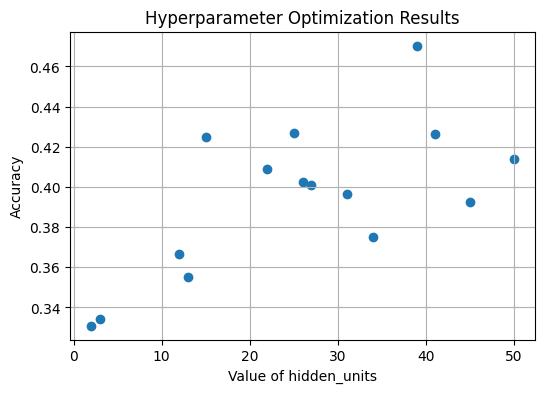

In [61]:
import matplotlib.pyplot as plt

hyperparam_values = [t.params['hidden_units'] for t in complete_trials]
accuracies = [t.value for t in complete_trials]

plt.figure(figsize=(6, 4))
plt.scatter(hyperparam_values, accuracies)
plt.title('Hyperparameter Optimization Results')
plt.xlabel('Value of hidden_units')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

More neurons on the hidden layers is better (when considering the range 5-50). It makes sense!

Few of you might have a problem: we've only allowed 15 trials, but `Optuna` tried twice the same trial (unlikely if you set a big range but likely if you only allowed the range [5; 8] for example. An example: https://i.imgur.com/DceMhuf.png). This is because `Optuna` doesn't check if it already has used the previous set of hyperparameters. To fix this, we can add the following code:

```py
from optuna.trial import TrialState

def objective(trial: optuna.trial.Trial) -> float:
    for previous_trial in trial.study.trials:
        if previous_trial.state == TrialState.COMPLETE and trial.params == previous_trial.params:
            print(f"Duplicated trial: {trial.params}, return {previous_trial.value}")
            return previous_trial.value
    ...
...
```

And even setting n_trials to 5000, we won't have optuna running two "experiments" with the same hyperparameters.

Let's add this and let's also optimize on the learning rate, the number of epochs, the use of batch normalisation layers, and the optimizer's choice.

We also add some manual pruning.

In [62]:
from optuna.exceptions import TrialPruned
from optuna.trial import TrialState

def objective(trial: optuna.trial.Trial) -> float:
    print("New trial")

    for previous_trial in trial.study.trials:
        if previous_trial.state == TrialState.COMPLETE and trial.params == previous_trial.params:
            print(f"Duplicated trial: {trial.params}, return {previous_trial.value}")
            return previous_trial.value
        
    # Set up cross validation
    n_splits: int = 5
    fold = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    scores = [0]*n_splits

    # Manual pruning
    try:
        best_score = trial.study.best_value
    except ValueError:
        best_score = 0

    # Hyperparameters choice
    hidden_units: int = trial.suggest_int('hidden_units', 2, 1000)
    learning_rate: float = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimiser: str = trial.suggest_categorical('optimiser', ['SGD', 'Adam'])
    num_epochs: int = trial.suggest_int('epochs', 5, 20)
    batch_norm: bool = trial.suggest_categorical('batch_norm', [True, False])
    use_conv: bool = trial.suggest_categorical('use_conv', [True, False])

    # Loop through data loader data batches
    for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(range(len(TRAIN_DATALOADER.dataset)))):
        # train_idx and valid_idx are numpy arrays of indices of the training and validation sets for this 
        # fold respectively.
        # They do not contain the actual data, but the indices of the data in the dataset.
        # We can use these indices to create a subset of the dataset for this fold with torch.utils.data.Subset.
        # Obviously, if an index is in the validation set, it will not be in the training set. You could
        # check this by printing train_idx and valid_idx and check by yourself.
        
        print(f"Fold {fold_idx+1}/{n_splits}")

        # Create subsets of the dataset for this fold
        sub_train_data = torch.utils.data.Subset(TRAIN_DATALOADER.dataset, train_idx)
        sub_valid_data = torch.utils.data.Subset(TRAIN_DATALOADER.dataset, valid_idx)

        # Create data loaders for this fold
        sub_train_loader = torch.utils.data.DataLoader(sub_train_data, batch_size=BATCH_SIZE, shuffle=True)
        sub_valid_loader = torch.utils.data.DataLoader(sub_valid_data, batch_size=BATCH_SIZE, shuffle=False)
        
        # Generate the model.
        my_model: Net = Net(
            hidden_units=hidden_units,
            batch_norm=batch_norm,
            use_conv=use_conv
        ).to(DEVICE)
        
        for epoch in range(num_epochs):
            # Training of the model.
            # Put model in train mode
            my_model.train()

            # Set up optimizer
            if optimiser == 'SGD':
                optimizer = torch.optim.SGD(my_model.parameters(), lr=learning_rate)
            elif optimiser == 'Adam':
                optimizer = torch.optim.Adam(my_model.parameters(), lr=learning_rate)
            else:
                raise ValueError(f"Unknown optimiser {optimiser}")

            # Set up loss function
            loss_fn = nn.CrossEntropyLoss()
            for X, y in sub_train_loader:
                # 1. Move data to device
                X = X.to(DEVICE)
                y = y.to(DEVICE)

                # 2. Forward pass
                y_pred = my_model(X)

                # 3. Calculate and accumulate loss
                loss = loss_fn(y_pred, y)

                # 4. Optimizer zero grad
                optimizer.zero_grad()

                # 5. Loss backward
                loss.backward()

                # 6. Optimizer step
                optimizer.step()

        # Validation of the model.
        # Put model in eval mode
        my_model.eval()
        
        val_acc = 0
        with torch.no_grad():
            for X, y in sub_valid_loader:
                # 1. Move data to device
                X = X.to(DEVICE)
                y = y.to(DEVICE)

                # 2. Forward pass
                y_pred = my_model(X)
                
                # 3. Compute accuracy
                y_pred_class = y_pred.argmax(dim=1)

                val_acc += (y_pred_class == y).sum()

        scores[fold_idx] = (val_acc.cpu() / len(sub_valid_data))
        # bring it back otherwise, np.mean will not work
        print(f"Fold {fold_idx+1}/{n_splits} accuracy: {scores[fold_idx]}")

        if fold_idx != 5 and np.mean(scores[:fold_idx+1]) < best_score * 0.7:
            print("Pruning trial")
            raise TrialPruned()
    
    return np.mean(scores)

In [63]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=3600, n_trials=20) 
# - timeout = 3600 -> stops after 60 minutes;
# - n_trials = 20 -> tries 20 different values for the hyperparameter.

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n")
print("--------------------")
print("--------------------")
print("--------------------")
print("\n")
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print(f"\t{key}: {value}")

[I 2026-01-18 13:59:13,958] A new study created in memory with name: no-name-b4004f9a-05a4-4738-aa69-98ca27166e0d


New trial
Fold 1/5
Fold 1/5 accuracy: 0.5458787083625793
Fold 2/5
Fold 2/5 accuracy: 0.5583203434944153
Fold 3/5
Fold 3/5 accuracy: 0.5887850522994995
Fold 4/5
Fold 4/5 accuracy: 0.5763239860534668
Fold 5/5
Fold 5/5 accuracy: 0.618380069732666


[I 2026-01-18 13:59:46,054] Trial 0 finished with value: 0.5775376558303833 and parameters: {'hidden_units': 505, 'learning_rate': 0.0002927475705704991, 'optimiser': 'SGD', 'epochs': 19, 'batch_norm': True, 'use_conv': True}. Best is trial 0 with value: 0.5775376558303833.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.5474339127540588
Fold 2/5
Fold 2/5 accuracy: 0.570762038230896
Fold 3/5
Fold 3/5 accuracy: 0.4657320976257324
Fold 4/5
Fold 4/5 accuracy: 0.573208749294281
Fold 5/5
Fold 5/5 accuracy: 0.4828660488128662


[I 2026-01-18 13:59:54,718] Trial 1 finished with value: 0.5280005931854248 and parameters: {'hidden_units': 940, 'learning_rate': 0.08343028242542111, 'optimiser': 'Adam', 'epochs': 14, 'batch_norm': True, 'use_conv': False}. Best is trial 0 with value: 0.5775376558303833.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.5660964250564575
Fold 2/5
Fold 2/5 accuracy: 0.6594090461730957
Fold 3/5
Fold 3/5 accuracy: 0.5919002890586853
Fold 4/5
Fold 4/5 accuracy: 0.573208749294281
Fold 5/5
Fold 5/5 accuracy: 0.6604361534118652


[I 2026-01-18 14:00:28,565] Trial 2 finished with value: 0.610210120677948 and parameters: {'hidden_units': 547, 'learning_rate': 0.0009539617431211564, 'optimiser': 'Adam', 'epochs': 19, 'batch_norm': True, 'use_conv': True}. Best is trial 2 with value: 0.610210120677948.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.5987558364868164
Fold 2/5
Fold 2/5 accuracy: 0.6454121470451355
Fold 3/5
Fold 3/5 accuracy: 0.6059190034866333
Fold 4/5
Fold 4/5 accuracy: 0.545171320438385
Fold 5/5
Fold 5/5 accuracy: 0.6433022022247314


[I 2026-01-18 14:00:54,687] Trial 3 finished with value: 0.6077121496200562 and parameters: {'hidden_units': 580, 'learning_rate': 1.5434544345359737e-05, 'optimiser': 'Adam', 'epochs': 19, 'batch_norm': False, 'use_conv': True}. Best is trial 2 with value: 0.610210120677948.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.5256609916687012
Fold 2/5
Fold 2/5 accuracy: 0.5816485285758972
Fold 3/5
Fold 3/5 accuracy: 0.5809968709945679
Fold 4/5
Fold 4/5 accuracy: 0.5545171499252319
Fold 5/5
Fold 5/5 accuracy: 0.6121495366096497


[I 2026-01-18 14:01:02,652] Trial 4 finished with value: 0.5709946155548096 and parameters: {'hidden_units': 845, 'learning_rate': 9.331017037478565e-05, 'optimiser': 'SGD', 'epochs': 20, 'batch_norm': True, 'use_conv': False}. Best is trial 2 with value: 0.610210120677948.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.6111975312232971
Fold 2/5
Fold 2/5 accuracy: 0.6594090461730957
Fold 3/5
Fold 3/5 accuracy: 0.6199377179145813
Fold 4/5
Fold 4/5 accuracy: 0.6510903239250183
Fold 5/5
Fold 5/5 accuracy: 0.6059190034866333


[I 2026-01-18 14:01:24,587] Trial 5 finished with value: 0.6295107007026672 and parameters: {'hidden_units': 790, 'learning_rate': 8.32274524239097e-05, 'optimiser': 'Adam', 'epochs': 15, 'batch_norm': False, 'use_conv': True}. Best is trial 5 with value: 0.6295107007026672.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.46656298637390137
Fold 2/5
Fold 2/5 accuracy: 0.5427682995796204
Fold 3/5
Fold 3/5 accuracy: 0.559190034866333
Fold 4/5
Fold 4/5 accuracy: 0.5700934529304504
Fold 5/5
Fold 5/5 accuracy: 0.5155763030052185


[I 2026-01-18 14:01:53,039] Trial 6 finished with value: 0.5308381915092468 and parameters: {'hidden_units': 642, 'learning_rate': 0.055145135287352834, 'optimiser': 'SGD', 'epochs': 17, 'batch_norm': True, 'use_conv': True}. Best is trial 5 with value: 0.6295107007026672.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.4276827275753021
Pruning trial


[I 2026-01-18 14:01:57,857] Trial 7 pruned. 


New trial
Fold 1/5
Fold 1/5 accuracy: 0.3405909836292267
Pruning trial


[I 2026-01-18 14:02:01,438] Trial 8 pruned. 


New trial
Fold 1/5
Fold 1/5 accuracy: 0.4432348310947418
Fold 2/5
Fold 2/5 accuracy: 0.40590980648994446
Pruning trial


[I 2026-01-18 14:02:08,716] Trial 9 pruned. 


New trial
Fold 1/5
Fold 1/5 accuracy: 0.3685847520828247
Pruning trial


[I 2026-01-18 14:02:09,356] Trial 10 pruned. 


New trial
Fold 1/5
Fold 1/5 accuracy: 0.5847589373588562
Fold 2/5
Fold 2/5 accuracy: 0.6765163540840149
Fold 3/5
Fold 3/5 accuracy: 0.644859790802002
Fold 4/5
Fold 4/5 accuracy: 0.6526479721069336
Fold 5/5
Fold 5/5 accuracy: 0.6869158744812012


[I 2026-01-18 14:02:24,066] Trial 11 finished with value: 0.6491397619247437 and parameters: {'hidden_units': 751, 'learning_rate': 0.0016668872087794093, 'optimiser': 'Adam', 'epochs': 10, 'batch_norm': False, 'use_conv': True}. Best is trial 11 with value: 0.6491397619247437.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.32814928889274597
Pruning trial


[I 2026-01-18 14:02:26,608] Trial 12 pruned. 


New trial
Fold 1/5
Fold 1/5 accuracy: 0.6003110408782959
Fold 2/5
Fold 2/5 accuracy: 0.5925350189208984
Fold 3/5
Fold 3/5 accuracy: 0.5545171499252319
Fold 4/5
Fold 4/5 accuracy: 0.5747663378715515
Fold 5/5
Fold 5/5 accuracy: 0.6510903239250183


[I 2026-01-18 14:02:39,472] Trial 13 finished with value: 0.5946439504623413 and parameters: {'hidden_units': 999, 'learning_rate': 0.0004898996275162137, 'optimiser': 'Adam', 'epochs': 8, 'batch_norm': False, 'use_conv': True}. Best is trial 11 with value: 0.6491397619247437.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.39191290736198425
Pruning trial


[I 2026-01-18 14:02:40,379] Trial 14 pruned. 


New trial
Fold 1/5
Fold 1/5 accuracy: 0.5769829154014587
Fold 2/5
Fold 2/5 accuracy: 0.6111975312232971
Fold 3/5
Fold 3/5 accuracy: 0.6339563727378845
Fold 4/5
Fold 4/5 accuracy: 0.6401869058609009
Fold 5/5
Fold 5/5 accuracy: 0.6401869058609009


[I 2026-01-18 14:02:57,895] Trial 15 finished with value: 0.6205021142959595 and parameters: {'hidden_units': 701, 'learning_rate': 0.00018617942753645033, 'optimiser': 'Adam', 'epochs': 12, 'batch_norm': False, 'use_conv': True}. Best is trial 11 with value: 0.6491397619247437.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.5816485285758972
Fold 2/5
Fold 2/5 accuracy: 0.6516329646110535
Fold 3/5
Fold 3/5 accuracy: 0.644859790802002
Fold 4/5
Fold 4/5 accuracy: 0.5965732336044312
Fold 5/5
Fold 5/5 accuracy: 0.6526479721069336


[I 2026-01-18 14:03:21,615] Trial 16 finished with value: 0.6254724860191345 and parameters: {'hidden_units': 863, 'learning_rate': 0.001748767728029018, 'optimiser': 'Adam', 'epochs': 16, 'batch_norm': False, 'use_conv': True}. Best is trial 11 with value: 0.6491397619247437.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.32814928889274597
Pruning trial


[I 2026-01-18 14:03:24,323] Trial 17 pruned. 


New trial
Fold 1/5
Fold 1/5 accuracy: 0.5412130355834961
Fold 2/5
Fold 2/5 accuracy: 0.5443235039710999
Fold 3/5
Fold 3/5 accuracy: 0.4813084006309509
Fold 4/5
Fold 4/5 accuracy: 0.4844236671924591
Fold 5/5
Fold 5/5 accuracy: 0.5249221324920654


[I 2026-01-18 14:03:26,544] Trial 18 finished with value: 0.5152381658554077 and parameters: {'hidden_units': 377, 'learning_rate': 1.06820809882939e-05, 'optimiser': 'Adam', 'epochs': 5, 'batch_norm': False, 'use_conv': False}. Best is trial 11 with value: 0.6491397619247437.


New trial
Fold 1/5
Fold 1/5 accuracy: 0.6096423268318176
Fold 2/5
Fold 2/5 accuracy: 0.6718506813049316
Fold 3/5
Fold 3/5 accuracy: 0.6199377179145813
Fold 4/5
Fold 4/5 accuracy: 0.6277258396148682
Fold 5/5
Fold 5/5 accuracy: 0.6682242751121521


[I 2026-01-18 14:03:45,426] Trial 19 finished with value: 0.6394761800765991 and parameters: {'hidden_units': 683, 'learning_rate': 0.0007166859653547943, 'optimiser': 'Adam', 'epochs': 13, 'batch_norm': False, 'use_conv': True}. Best is trial 11 with value: 0.6491397619247437.




--------------------
--------------------
--------------------


Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  7
  Number of complete trials:  13
Best trial:
  Value:  0.6491397619247437
  Params: 
	hidden_units: 751
	learning_rate: 0.0016668872087794093
	optimiser: Adam
	epochs: 10
	batch_norm: False
	use_conv: True


Let's now train the whole model with the optimal hyperparameters that we found with Optuna. We will use the `study.best_params` attribute to get the best hyperparameters. You need to re-train on the whole training dataset!!! Otherwise, you will not get the best accuracy as you're leaving out some data.

In [64]:
study.best_params  # display the best hyperparameters

{'hidden_units': 751,
 'learning_rate': 0.0016668872087794093,
 'optimiser': 'Adam',
 'epochs': 10,
 'batch_norm': False,
 'use_conv': True}

In [78]:
# Create model
MODEL: Net = Net(hidden_units=study.best_params['hidden_units'], batch_norm = study.best_params['batch_norm'], use_conv = study.best_params['use_conv']).to(DEVICE)

# Set number of epochs
NUM_EPOCHS = study.best_params['epochs']

In [79]:
print(MODEL)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=751, bias=True)
  (fc2): Linear(in_features=751, out_features=3, bias=True)
)


In [80]:
optimiser = (
    torch.optim.SGD(MODEL.parameters(), lr=study.best_params['learning_rate']) 
    if study.best_params['optimiser'] == 'SGD' 
    else 
    torch.optim.Adam(MODEL.parameters(), lr=study.best_params['learning_rate'])
)
print(optimiser)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0016668872087794093
    maximize: False
    weight_decay: 0
)


In [81]:
main_train(
    nn.CrossEntropyLoss(), 
    torch.optim.SGD(MODEL.parameters(), lr=study.best_params['learning_rate']) if study.best_params['optimiser'] == 'SGD' 
    else torch.optim.Adam(MODEL.parameters(), lr=study.best_params['learning_rate'])
)

epoch 1/10, train_loss = 5.92e-03, train_acc = 35.46%, time spent during this epoch = 0.57s, total time spent = 0.57s
epoch 2/10, train_loss = 2.45e-03, train_acc = 33.41%, time spent during this epoch = 0.36s, total time spent = 0.94s
epoch 3/10, train_loss = 2.27e-03, train_acc = 46.73%, time spent during this epoch = 0.36s, total time spent = 1.30s
epoch 4/10, train_loss = 1.96e-03, train_acc = 57.13%, time spent during this epoch = 0.36s, total time spent = 1.66s
epoch 5/10, train_loss = 1.89e-03, train_acc = 58.97%, time spent during this epoch = 0.36s, total time spent = 2.01s
epoch 6/10, train_loss = 1.74e-03, train_acc = 65.19%, time spent during this epoch = 0.37s, total time spent = 2.38s
epoch 7/10, train_loss = 1.66e-03, train_acc = 65.97%, time spent during this epoch = 0.36s, total time spent = 2.74s
epoch 8/10, train_loss = 1.58e-03, train_acc = 68.46%, time spent during this epoch = 0.35s, total time spent = 3.10s
epoch 9/10, train_loss = 1.53e-03, train_acc = 69.21%, t

In [82]:
test_our_model()

0.6487695574760437

Our performance went up by almost 10%! (Only 20 trials of hyperparameter optimisation)